In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.datasets import load_digits

In [2]:
def train_test_split_numpy(X, y, test_size=0.2, random_state=None):
    if random_state:
        np.random.seed(random_state)
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    split_idx = int(X.shape[0]*(1-test_size))
    return X[indices[:split_idx]], X[indices[split_idx:]], y[indices[:split_idx]], y[indices[split_idx:]]

In [3]:
def standard_scaler_numpy(X_train, X_test):
    mean = np.mean(X_train, axis=0)
    std = np.std(X_train, axis=0) + 1e-8
    return (X_train-mean)/std, (X_test - mean) / std

In [4]:
def relu(x):
    return np.maximum(0, x)


def relu_derivative(x):
    return (x > 0).astype(float)


def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)


In [5]:
def cross_entropy(y_pred, y_true):
    n_samples = y_true.shape[0]
    log_likelihood = -np.log(y_pred[range(n_samples), y_true]+1e-9)
    return np.sum(log_likelihood) / n_samples


In [6]:
def l2_regularization(params, reg_lambda):
    return 0.5 * reg_lambda * sum(np.sum(w**2)for k, w in params.items() if 'w' in k)

In [7]:
def adam_update(params, grads, v, s, t, lr=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
    for key in params:
        v[key] = beta1*v[key]+(1-beta1)*grads[key]
        s[key] = beta2*s[key]+(1-beta2)*(grads[key]**2)
        v_corrected = v[key] / (1-beta1 ** t)
        s_corrected = s[key] / (1-beta2 ** t)

        params[key] -= lr * v_corrected / (np.sqrt(s_corrected) + epsilon)
    return params, v, s

In [8]:
class MLPClassifier:
    def __init__(self, input_dim, hidden_dim, output_dim, lr=0.001, reg_lambda=0.01):
        self.lr = lr
        self.reg_lambda = reg_lambda
        self.params = {
            "W1": np.random.randn(input_dim, hidden_dim) * 0.01,
            "b1": np.zeros((1, hidden_dim)),
            "W2": np.random.randn(hidden_dim, output_dim)*0.01,
            "b2": np.zeros((1, output_dim))
        }
        self.v = {key: np.zeros_like(value)
                  for key, value in self.params.items()}
        self.s = {key: np.zeros_like(value)
                  for key, value in self.params.items()}
        self.t = 1

    def forward(self, X):
        self.z1 = X @ self.params['W1'] + self.params['b1']
        self.a1 = relu(self.z1)
        self.z2 = self.a1 @ self.params['W2'] + self .params['b2']
        self.a2 = softmax(self.z2)
        return self.a2

    def backward(self, X, y_true):
        m = X.shape[0]
        y_pred = self.a2
        y_true_one_hot = np.zeros_like(y_pred)
        y_true_one_hot[np.arange(m), y_true] = 1
        dz2 = y_pred - y_true_one_hot
        dW2 = self.a1.T @ dz2 / m + self.reg_lambda*self.params['W2']
        db2 = np.sum(dz2, axis=0, keepdims=True) / m
        dz1 = dz2 @ self.params["W2"].T * relu_derivative(self.z1)
        dW1 = X.T @ dz1 / m + self. reg_lambda*self.params['W1']
        db1 = np.sum(dz1, axis=0, keepdims=True) / m
        return {'W1': dW1, 'b1': db1, 'W2': dW2, 'b2': db2}

    def train(self,
              X_train,
              y_train,
              X_val,
              y_val,
              epochs=50,
              batch_size=64,
              verbose=True,
              early_stop=5,
              loss_threshold=1e-4):
        
        train_losses = []
        val_losses = []
        val_accuracies = []

        best_val_loss = float("inf")
        patience = 0
        for epoch in range(epochs):
            indices = np.arange(X_train.shape[0])
            np.random.shuffle(indices)
            X_train, y_train = X_train[indices], y_train[indices]

            for i in range(0, X_train.shape[0], batch_size):
                X_batch = X_train[i:i + batch_size]
                y_batch = y_train[i:i + batch_size]
                y_pred = self.forward(X_batch)
                grads = self.backward(X_batch, y_batch)
                self.params, self.v , self.s= adam_update(self.params, grads, self.v,self.s, self.t, self.lr)
                self.t += 1

            train_loss = cross_entropy(self.forward(
                X_train), y_train) + l2_regularization(self.params, self.reg_lambda)
            val_loss = cross_entropy(self.forward(
                X_val), y_val)+l2_regularization(self.params, self.reg_lambda)
            val_acc = np.mean(self.predict(X_val) == y_val)

            train_losses.append(train_loss)
            val_losses.append(val_loss)
            val_accuracies.append(val_acc)

            if verbose:
                print(
                    f"Epoch : {epoch+1}, Train Loss : {train_loss: .4f}, Val Loss : {val_loss: .4f}, Val Acc {val_acc: .4}")

            if early_stop is not None:
                if best_val_loss - val_loss < loss_threshold:
                    patience += 1
                else:
                    best_val_loss = val_loss
                    print("Patience :",patience)
                    patience = 0
                if patience >= early_stop:
                    print("Early stopping triggered!")
                    break
        
                # نمودار Train Loss
        plt.figure(figsize=(6, 4))
        plt.plot(train_losses, label='Train Loss', color='blue')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Train Loss over Epochs')
        plt.legend()
        plt.grid(True)
        plt.show()

        # نمودار Validation Loss
        plt.figure(figsize=(6, 4))
        plt.plot(val_losses, label='Validation Loss', color='orange')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Validation Loss over Epochs')
        plt.legend()
        plt.grid(True)
        plt.show()

        # نمودار Validation Accuracy
        plt.figure(figsize=(6, 4))
        plt.plot(val_accuracies, label='Validation Accuracy', color='green')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title('Validation Accuracy over Epochs')
        plt.legend()
        plt.grid(True)
        plt.show()



    def predict(self, X):
        return np.argmax(self.forward(X), axis=1)


Epoch : 1, Train Loss :  2.0707, Val Loss :  2.0830, Val Acc  0.6979
Patience : 0
Epoch : 2, Train Loss :  1.4939, Val Loss :  1.5280, Val Acc  0.7118
Patience : 0
Epoch : 3, Train Loss :  0.9167, Val Loss :  0.9596, Val Acc  0.7535
Patience : 0
Epoch : 4, Train Loss :  0.5998, Val Loss :  0.6286, Val Acc  0.8576
Patience : 0
Epoch : 5, Train Loss :  0.4323, Val Loss :  0.4451, Val Acc  0.8958
Patience : 0
Epoch : 6, Train Loss :  0.3299, Val Loss :  0.3398, Val Acc  0.9271
Patience : 0
Epoch : 7, Train Loss :  0.2599, Val Loss :  0.2599, Val Acc  0.9549
Patience : 0
Epoch : 8, Train Loss :  0.2104, Val Loss :  0.2093, Val Acc  0.9618
Patience : 0
Epoch : 9, Train Loss :  0.1758, Val Loss :  0.1784, Val Acc  0.9583
Patience : 0
Epoch : 10, Train Loss :  0.1498, Val Loss :  0.1558, Val Acc  0.9653
Patience : 0


Epoch : 11, Train Loss :  0.1305, Val Loss :  0.1394, Val Acc  0.9653
Patience : 0
Epoch : 12, Train Loss :  0.1141, Val Loss :  0.1276, Val Acc  0.9688
Patience : 0
Epoch : 13, Train Loss :  0.1017, Val Loss :  0.1180, Val Acc  0.9722
Patience : 0
Epoch : 14, Train Loss :  0.0912, Val Loss :  0.1117, Val Acc  0.9722
Patience : 0
Epoch : 15, Train Loss :  0.0825, Val Loss :  0.1049, Val Acc  0.9722
Patience : 0
Epoch : 16, Train Loss :  0.0745, Val Loss :  0.1018, Val Acc  0.9722
Patience : 0
Epoch : 17, Train Loss :  0.0681, Val Loss :  0.0963, Val Acc  0.9757
Patience : 0
Epoch : 18, Train Loss :  0.0625, Val Loss :  0.0932, Val Acc  0.9757
Patience : 0
Epoch : 19, Train Loss :  0.0575, Val Loss :  0.0901, Val Acc  0.9757
Patience : 0
Epoch : 20, Train Loss :  0.0530, Val Loss :  0.0877, Val Acc  0.9757
Patience : 0
Epoch : 21, Train Loss :  0.0490, Val Loss :  0.0866, Val Acc  0.9757
Patience : 0
Epoch : 22, Train Loss :  0.0456, Val Loss :  0.0835, Val Acc  0.9792
Patience : 0
Epoc

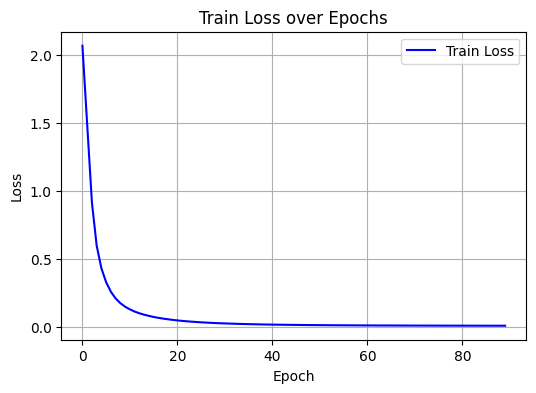

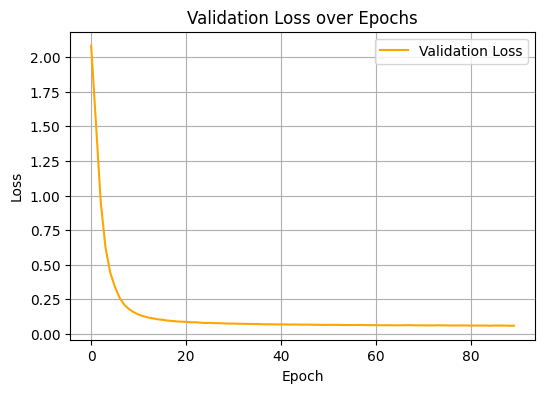

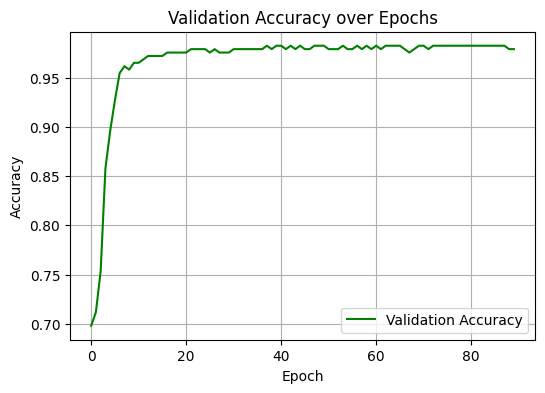

Test Accuracy :  0.9694


In [9]:
digits = load_digits()
X = digits.data/16.0
y = digits.target

X_train, X_test, y_train, y_test = train_test_split_numpy(
    X, y, test_size=0.2, random_state=42)

X_train,X_test = standard_scaler_numpy(X_train,X_test)

X_train, X_val, y_train, y_val = train_test_split_numpy(
    X_train, y_train, test_size=0.2, random_state=42)


mlp = MLPClassifier(input_dim=64,
                    hidden_dim=128,
                    output_dim=10,
                    lr=0.001,
                    reg_lambda=0.001)

mlp.train(X_train, y_train, X_val, y_val, epochs=100, batch_size=64,verbose=True, early_stop=5, loss_threshold=1e-4)

y_pred = mlp.predict(X_test)
accuracy = np.mean(y_pred == y_test)
print(f"Test Accuracy : {accuracy: .4f}")